In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torch.utils.data import Subset      # it is used to split our data
from torchvision import datasets, transforms
from torchsummary import summary
import torchvision.models as models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import torch.optim as optim

In [3]:
# Data loading
train_data_dir = r'C:\Users\computer\Desktop\chest\train'
test_data_dir = r'C:\Users\computer\Desktop\chest\test'

# Training transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(15),  # Randomly rotate images
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Testing transformations (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Load the training dataset with training transforms
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=train_transform)
trainloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Load the testing dataset with testing transforms
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_transform)
testloader = DataLoader(test_dataset, batch_size=8, shuffle=False)


# Number of classes
num_classes = len(train_dataset.classes)
print (f'Number of class: {num_classes}')
class_names = train_dataset.classes
print (f'Name of class: {class_names}')
print (f'Train dataset:{len(train_dataset)}')
print (f'Test dataset:{len(test_dataset)}')

# Dataloaders dictionary
dataloaders = {
    'train': trainloader,
    'val': testloader  # Using testloader as validation set
}

Number of class: 2
Name of class: ['NORMAL', 'PNEUMONIA']
Train dataset:5216
Test dataset:624


In [4]:
first_batch = next(iter(trainloader))
images, labels = first_batch
print("Batch shape:", images.shape)

Batch shape: torch.Size([8, 3, 224, 224])


In [5]:
# Load pre-trained ResNet-18
model = models.resnet18(pretrained=True)


num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


C:\Users\computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [7]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
def training(model, dataloaders, criterion, optimizer, num_epochs):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    val_acc_history = []
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Start timing the epoch
        start_time = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store history
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

                # Deep copy the model if it has the best accuracy
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()

        # End timing the epoch
        end_time = time.time()
        epoch_duration = end_time - start_time
        print(f'Epoch {epoch + 1} duration: {epoch_duration:.2f} seconds')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_loss_history, train_acc_history, val_loss_history


In [9]:
# Run the training
num_epochs = 50  # Set your number of epochs
best_model, val_acc_history, train_loss_history, train_acc_history, val_loss_history = training(model, dataloaders, criterion, optimizer, num_epochs)

Epoch 1/50
----------
train Loss: 0.2241 Acc: 0.9118
val Loss: 1.2610 Acc: 0.7484
Epoch 1 duration: 102.83 seconds
Epoch 2/50
----------
train Loss: 0.1527 Acc: 0.9463
val Loss: 0.5153 Acc: 0.8734
Epoch 2 duration: 105.73 seconds
Epoch 3/50
----------
train Loss: 0.1331 Acc: 0.9507
val Loss: 0.7930 Acc: 0.8141
Epoch 3 duration: 105.69 seconds
Epoch 4/50
----------
train Loss: 0.1252 Acc: 0.9523
val Loss: 0.8082 Acc: 0.7885
Epoch 4 duration: 105.84 seconds
Epoch 5/50
----------
train Loss: 0.1085 Acc: 0.9588
val Loss: 1.3134 Acc: 0.6843
Epoch 5 duration: 105.69 seconds
Epoch 6/50
----------
train Loss: 0.0942 Acc: 0.9659
val Loss: 0.4675 Acc: 0.8686
Epoch 6 duration: 105.30 seconds
Epoch 7/50
----------
train Loss: 0.0828 Acc: 0.9672
val Loss: 1.1753 Acc: 0.7436
Epoch 7 duration: 105.02 seconds
Epoch 8/50
----------
train Loss: 0.0875 Acc: 0.9703
val Loss: 0.8554 Acc: 0.8173
Epoch 8 duration: 104.59 seconds
Epoch 9/50
----------
train Loss: 0.0820 Acc: 0.9705
val Loss: 0.9288 Acc: 0.783

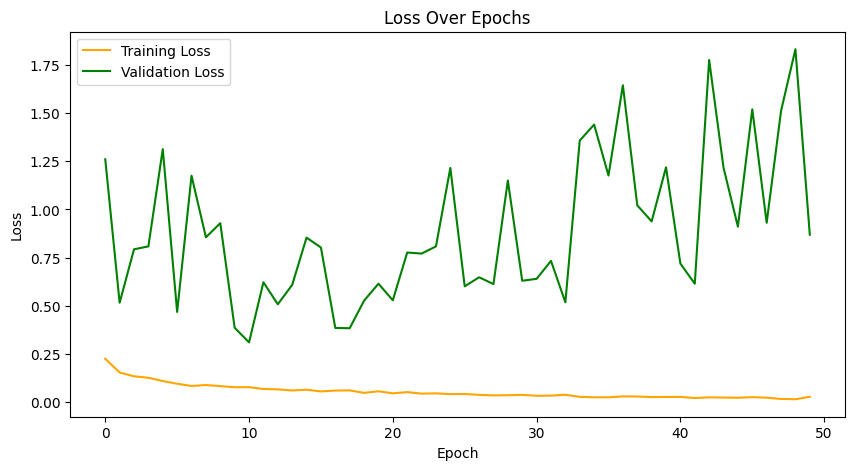

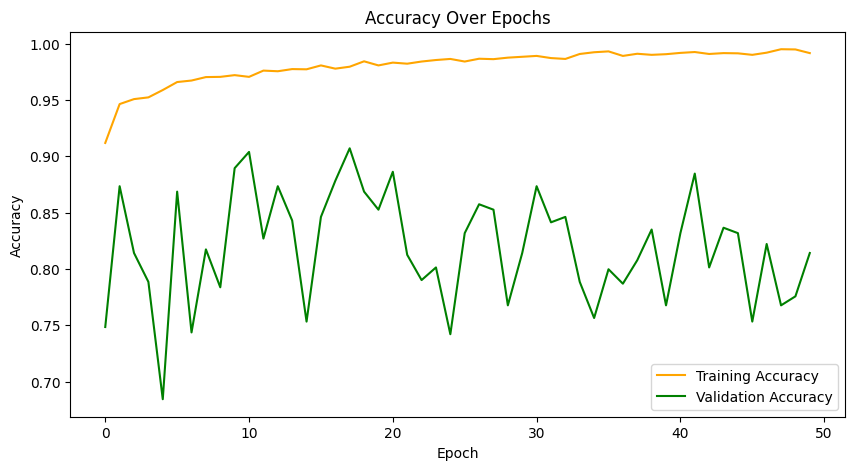

In [11]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss', color='orange')
plt.plot(val_loss_history, label='Validation Loss', color='green')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Training Accuracy', color='orange')
plt.plot(val_acc_history, label='Validation Accuracy', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()